In [1]:
# 環境設定
!pip install pandas sklearn
!pip install pystan
!pip install statsmodels
!pip install fbprophet

    100% |████████████████████████████████| 7.6MB 814kB/s ta 0:00:011
  Running setup.py install for sklearn ... done
    100% |████████████████████████████████| 48.0MB 333kB/s ta 0:00:011
    100% |████████████████████████████████| 5.1MB 1.8MB/s ta 0:00:01
    100% |████████████████████████████████| 5.4MB 2.5MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 8.2MB/s ta 0:00:011
    100% |████████████████████████████████| 16.3MB 616kB/s ta 0:00:011   45% |██████████████▋                 | 7.5MB 7.1MB/s eta 0:00:02
    100% |████████████████████████████████| 13.6MB 759kB/s ta 0:00:011
    100% |████████████████████████████████| 112kB 3.1MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 3.1MB/s ta 0:00:011
  Running setup.py install for fbprophet ... done


In [2]:
# 定数

# 何時点まで遡ったデータを使うか
LENGTH_OF_SEQUENCE = 50

# 予測区間
PREDICTION_INTERVAL=0.90
PREDICTION_LABEL="{}% prediction interval".format(PREDICTION_INTERVAL*100)

# 未使用データサイズ
TEST_SIZE = 50

In [3]:
import pandas as pd

df = pd.read_csv("nikkei_stock_average_daily_jp.csv", index_col=0, parse_dates=[0])
print(type(df.index))
df.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,closing_price,starting_price,high_price,low_price
date,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,16883.19,17101.58,17111.36,16881.73
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53


In [121]:
# 平日しかデータがないためfreqを設定するとNaNが発生してしまう
#df.asfreq('D')
# http://sinhrks.hatenablog.com/entry/2015/05/18/233505

,closing_price,starting_price,high_price,low_price
date,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,16883.19,17101.58,17111.36,16881.73
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53
2015-01-10,NaN,NaN,NaN,NaN
2015-01-11,NaN,NaN,NaN,NaN
2015-01-12,NaN,NaN,NaN,NaN
2015-01-13,17087.71,16970.88,17087.71,16828.27


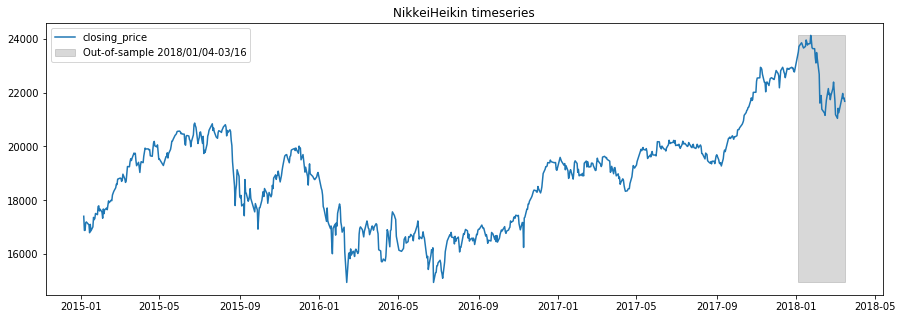

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

train_df = df.iloc[0:-TEST_SIZE]
test_df = df.iloc[-TEST_SIZE:]
train_size = len(train_df)

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['closing_price'], label="closing_price")
plt.fill_between(test_df.index, df['closing_price'].min(), df['closing_price'].max(), color='grey', alpha=0.3, 
                 label='Out-of-sample {}-{}'.format(test_df.first_valid_index().strftime('%Y/%m/%d'), test_df.last_valid_index().strftime('%m/%d')))
plt.title("NikkeiHeikin timeseries")
plt.legend()
plt.show()

In [6]:
import numpy as np
import random
random.seed(0)

"""
create sequence x, y data
"""
def load_data(data, maxlen, feature_x=['closing_price'], predict_y='closing_price'):
    features = data[feature_x]
    predict_col = data.columns.get_loc(predict_y)
    I = []
    X = []
    Y = []
    for i in range(features.shape[0]-maxlen-1):
        I.append(data.iloc[[i+maxlen]].index)
        X.append(features.iloc[i:i+maxlen].as_matrix())
        Y.append(np.array([data.iloc[i+maxlen, predict_col]]))
    return np.array(I), np.array(X), np.array(Y)

(trainIndex, trainX, trainY) = load_data(train_df, LENGTH_OF_SEQUENCE)
(testIndex, testX, testY) = load_data(df, LENGTH_OF_SEQUENCE)
testIndex = testIndex.reshape(-1)[len(trainY):]
testX = testX.reshape(-1, LENGTH_OF_SEQUENCE)[len(trainX):]
testY = testY.reshape(-1)[len(trainY):]

In [12]:
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.initializers import Constant, TruncatedNormal
from keras.models import Sequential  
from keras.layers.core import Dense, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

# Feature Neurons Size
IN_NEURONS = len(trainX[0][0])
HIDDEN_NEURONS = 200

def clear_session():
    # 通し番号など既にあるモデルを削除 (TensorboardのGraphにも影響)
    K.clear_session()

def create_model(length_of_sequence=LENGTH_OF_SEQUENCE, hidden_neurons=HIDDEN_NEURONS,
                 in_neurons=IN_NEURONS, mean=None, stddev=None, learning_rate=0.01):
    if stddev is None or mean is None:
        kernel_initializer = 'glorot_uniform'
    else:
        kernel_initializer = TruncatedNormal(mean=mean, stddev=stddev)
    
    if mean is None:
        bias_initializer = 'zeros'
    else:
        bias_initializer = Constant(mean)
        
    model = Sequential()
    model.add(LSTM(hidden_neurons, 
              batch_input_shape=(None, length_of_sequence, in_neurons),
              return_sequences=False))
    model.add(Dense(1, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))

    # Mean absolute percentage error
    model.compile(loss="mape", optimizer=Adam(lr=learning_rate))
    
    return model

def create_tensorboard(log_dir):
    return TensorBoard( log_dir=log_dir
                        ,write_graph=False
                        ,histogram_freq=1
                        ,write_grads=True
                        ,write_images=1
                        )

In [ ]:
# TODO
# 入力が大きいのが悪いか、出力が大きいのが悪いかのあたりをつける
# 例えば出力は上がったか下がったかの2値分類の問題として解かせると良さそう
# 出力が小さければLOSSは下がるが、入力が大きいとそもそも学習がうまくいかない

# activation可視化
# https://dashee87.github.io/data%20science/deep%20learning/visualising-activation-functions-in-neural-networks/

# 正規分布を仮定している訳ではないので MinMax Scalerを使った方が良さそう
# http://ailaby.com/scaler/
# RobustScalerも良さそう
# https://qiita.com/unhurried/items/7a79d2f3574fb1d0cc27

# 正規化したくない理由
# 基本的には内部で抽象化して扱って欲しい
# 未知のデータが来た時にそれっぽい予測をしてくれることが学習がうまくいっていると考えたい

# http://www.renom.jp/ja/notebooks/preprocessing/time_series_interpolation/notebook.html

# 時系列ステップtを変数に予測モデルを構築
# 訓練データを増やすことができる
# 直接定数Tステップ後の予測モデルを構築するより精度有利かどうかを確かめる

# stan
# http://ksknw.hatenablog.com/entry/2016/12/11/184552
# http://statmodeling.hatenablog.com/entry/pystan-rstanbook-chap5-1

# https://funmatu.wordpress.com/2017/05/31/prophet%EF%BC%9Farima%EF%BC%9F%E5%A4%96%E3%82%8C%E5%80%A4%E6%A4%9C%E5%87%BA%EF%BC%9F/

In [17]:
clear_session()
model = create_model(mean=trainY.mean(), stddev=None)
callbacks = [create_tensorboard(log_dir='logs_lstm')]

In [18]:
hist = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.05, callbacks=callbacks)

Train on 650 samples, validate on 35 samples
Epoch 1/100
650/650 [==============================] - 4s 6ms/step - loss: 7.5741 - val_loss: 16.8098
Epoch 2/100
650/650 [==============================] - 3s 5ms/step - loss: 7.5736 - val_loss: 16.8012
Epoch 3/100
650/650 [==============================] - 3s 5ms/step - loss: 7.5733 - val_loss: 16.7903
Epoch 4/100
650/650 [==============================] - 3s 5ms/step - loss: 7.5730 - val_loss: 16.7825
Epoch 5/100
650/650 [==============================] - 3s 5ms/step - loss: 7.5727 - val_loss: 16.7777
Epoch 6/100
650/650 [==============================] - 3s 5ms/step - loss: 7.5724 - val_loss: 16.7713
Epoch 7/100
650/650 [==============================] - 3s 5ms/step - loss: 7.5722 - val_loss: 16.7654
Epoch 8/100
650/650 [==============================] - 3s 5ms/step - loss: 7.5719 - val_loss: 16.7582
Epoch 9/100
650/650 [==============================] - 3s 5ms/step - loss: 7.5718 - val_loss: 16.7516
Epoch 10/100
650/650 [===============

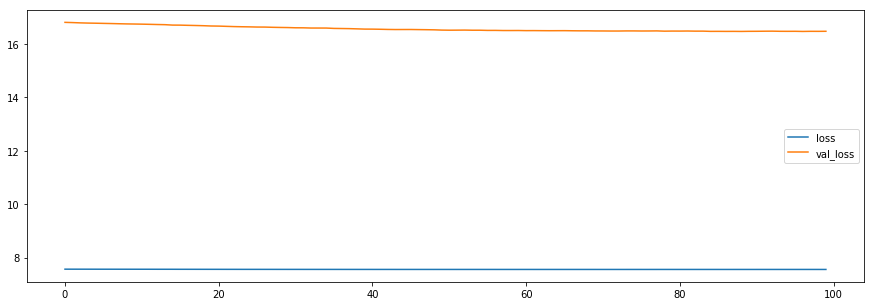

In [19]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(figsize=(15, 5))

In [45]:
#predicted = scaler.inverse_transform(model.predict(trainX[:1000]))
predicted = model.predict(trainX[:1000])
predicted_df = pd.DataFrame(predicted[:], columns=["predicted"])
predicted_df["actual"] = trainY[:1000]
predicted_df.plot(figsize=(15, 5))

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("lstm_1_input:0", shape=(?, 50, 1), dtype=float32) is not an element of this graph.

In [742]:
model.get_config()

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, 50, 3),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 1,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': False,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 200,
   'unroll': False,
   'u

In [615]:
# modelの最終層の重みを出力
# LSTM解説
# https://qiita.com/Ginom/items/b3a4a6e8c2c534d3f350

# Conv2 可視化
# http://ossyaritoori.hatenablog.com/entry/2017/06/02/Keras%E3%81%A7%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E4%BF%9D%E5%AD%98%E3%81%A8%E5%8F%AF%E8%A6%96%E5%8C%96

# warm cold 可視化
# https://qiita.com/kznx/items/83fb717dd26481997250

# lstm
# (入力次元数3, LSTMの入力層の入力に対する重み、入力ゲートの重み、出力ゲートの重み、忘却ゲートの重み800(200*4))
# (200, 隠れ層の入力に対する重み、入力ゲートの重み、出力ゲートの重み、忘却ゲートの重み 800(200*4))
# (800, (入力層、隠れ層に対するバイアス))

# (200, 出力層の入力に対する重み（隠れ層の出力に対する重み）1)
# (1, 出力層に対するバイアス（隠れ層の出力に対するバイアス）)

# LSTM解説参考
# http://russeng.hatenablog.jp/entry/2017/07/12/204738

# Tensorboardで可視化 (TODO: jupyter tensorboardで可視化できないかを試す)
# https://deepage.net/tensorflow/2017/04/25/tensorboard.html#%E3%83%92%E3%82%B9%E3%83%88%E3%82%B0%E3%83%A9%E3%83%A0

for i in range(len(model.layers)):
    print('Layer Name: {}'.format(model.layers[i].get_config()['name']))
    for weight in model.layers[i].get_weights():
        print(weight.shape)

Layer Name: lstm_21
(3, 800)
(200, 800)
(800,)
Layer Name: dense_21
(200, 1)
(1,)
Layer Name: activation_21


In [21]:
model.get_weights()

[array([[-0.01275579, -0.00202068, -0.05514196, -0.06398577,  0.06568119,
          0.07588072, -0.02677179,  0.02657367, -0.04205325, -0.04986673,
         -0.04060711,  0.07810093, -0.05078615,  0.0226775 ,  0.02074371,
          0.03665722,  0.02079788, -0.01842001,  0.07648629,  0.04488632,
         -0.02376935,  0.02646709,  0.04216318,  0.03440793, -0.04450161,
         -0.07580353, -0.02140392,  0.04136617, -0.02568237,  0.04044561,
          0.00625898,  0.0799336 ,  0.04735981, -0.04211451,  0.02365798,
          0.06656277, -0.08624763, -0.06882873, -0.02587087, -0.05506378,
          0.01442139,  0.06480208,  0.06487067, -0.06197063,  0.03801192,
         -0.08542686,  0.04096657,  0.04809067, -0.07971574, -0.02133983,
          0.01538922, -0.04873275,  0.03968146, -0.02542036,  0.03980547,
          0.01668081, -0.06939679, -0.04515414, -0.06252209,  0.05556738,
          0.01036295, -0.05469617, -0.06759671,  0.01313341,  0.01250178,
         -0.0461704 ,  0.00205436,  0.

In [665]:
modeldash.get_weights()

[array([[ 3.43922265e-02, -1.00254856e-01,  4.21789736e-02,
          6.54984564e-02,  3.28963157e-03,  9.01653469e-02,
          2.55230796e-02, -9.01232064e-02,  4.32793871e-02,
          3.93826887e-02, -9.00565311e-02,  1.17560895e-02,
          7.69818574e-02, -8.59236941e-02, -1.98109774e-03,
          1.34827062e-01, -9.48192701e-02,  4.28508967e-03,
         -6.48546666e-02, -9.41714179e-03, -2.53941528e-02,
         -1.90959293e-02,  1.14648929e-02,  3.34006995e-02,
          8.68501961e-02, -7.08714649e-02,  8.07990208e-02,
          6.13739938e-02,  1.96359735e-02,  4.27167770e-03,
          2.90485900e-02, -5.56660667e-02,  4.25930209e-02,
          3.94220985e-02,  5.68005405e-02,  1.16122484e-01,
          1.02286369e-01, -1.19219022e-02,  2.22123116e-02,
          7.38800466e-02, -6.02247976e-02,  1.07751358e-02,
          7.74826761e-03, -6.46047890e-02, -8.56952090e-03,
         -4.98747379e-02,  3.66338529e-02,  5.68549484e-02,
         -7.52476677e-02,  2.22821124e-0

In [707]:
# 誤差が大きいと勾配が消失する (LSTMでは恐らくこれが起こっている)
# http://nonbiri-tereka.hatenablog.com/entry/2016/03/10/073633
import numpy as np
def sigmoid(z):
    return 1/(1+np.exp(-z))

print(sigmoid(-500)) #7.1245764067412845e-218
print(sigmoid(-500).astype(np.float32)) #0.0
print(np.tanh(-500))
print(np.tanh(0))
print(np.tanh(0.01))
print(np.tanh(10))

7.124576406741285e-218
0.0
-1.0
0.0
0.00999966667999946
0.9999999958776927


In [572]:
layer_num = 0; # 1st convolutional layer
print('Layer Name: {}'.format(model.layers[layer_num].get_config()['name']))

Layer Name: lstm_19


In [586]:
model.layers[0].get_weights()

[array([[-0.01968422,  0.07024799,  0.05978564, ...,  0.07087011,
          0.0360891 , -0.01173537],
        [-0.02025721,  0.0484734 ,  0.0365628 , ..., -0.06911069,
         -0.02122427,  0.07440632],
        [-0.06252012,  0.02876421,  0.01059585, ..., -0.04823542,
         -0.01772137, -0.0434534 ]], dtype=float32),
 array([[ 0.07335383,  0.05148854, -0.02875614, ...,  0.10487422,
          0.05805831,  0.04138041],
        [-0.02762609, -0.02762783,  0.0048883 , ...,  0.01874712,
         -0.02266202, -0.01719936],
        [-0.00193055, -0.00675837, -0.00887879, ...,  0.0126979 ,
         -0.02403428,  0.02686797],
        ...,
        [ 0.04414536,  0.00839213, -0.04515999, ...,  0.0481309 ,
         -0.04168263,  0.00815126],
        [ 0.03081031,  0.0410992 , -0.05593529, ..., -0.05110384,
          0.00256434,  0.02668118],
        [-0.00298541,  0.03608992,  0.03615804, ...,  0.02340005,
         -0.00998289, -0.01488636]], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e

In [22]:
# using Scaler
from sklearn.preprocessing import RobustScaler #, StandardScaler, MinMaxScaler

NORM_COL = 'closing_price_norm'

scaler = RobustScaler()
train_df.loc[:, (NORM_COL)] = scaler.fit_transform(train_df[['closing_price']])

(trainXdash, trainYdash) = load_data(train_df, LENGTH_OF_SEQUENCE, [NORM_COL], NORM_COL)

# tensorflow logのGraphをきれいにしたい場合は有効にする
# clear_session()

modeldash = create_model(length_of_sequence=LENGTH_OF_SEQUENCE, in_neurons=1)
callbacksdash = [create_tensorboard(log_dir='logs_norm_lstm')]
histdash = modeldash.fit(trainXdash, trainYdash, batch_size=32, epochs=100, validation_split=0.05, callbacks=callbacksdash)

/home/ksgwr/venv/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ksgwr/venv/lib/python3.5/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Train on 650 samples, validate on 35 samples
Epoch 1/100
650/650 [==============================] - 4s 6ms/step - loss: 120.8769 - val_loss: 48.5710
Epoch 2/100
650/650 [==============================] - 3s 5ms/step - loss: 100.4027 - val_loss: 76.2179
Epoch 3/100
650/650 [==============================] - 3s 5ms/step - loss: 89.7508 - val_loss: 57.7866
Epoch 4/100
650/650 [==============================] - 3s 5ms/step - loss: 106.7594 - val_loss: 67.9862
Epoch 5/100
650/650 [==============================] - 3s 5ms/step - loss: 79.7157 - val_loss: 57.3522
Epoch 6/100
650/650 [==============================] - 3s 5ms/step - loss: 73.0358 - val_loss: 42.2013
Epoch 7/100
650/650 [==============================] - 3s 5ms/step - loss: 84.5692 - val_loss: 69.7225
Epoch 8/100
650/650 [==============================] - 3s 5ms/step - loss: 80.3962 - val_loss: 66.3074
Epoch 9/100
650/650 [==============================] - 3s 5ms/step - loss: 76.8016 - val_loss: 41.7095
Epoch 10/100
650/650 [===

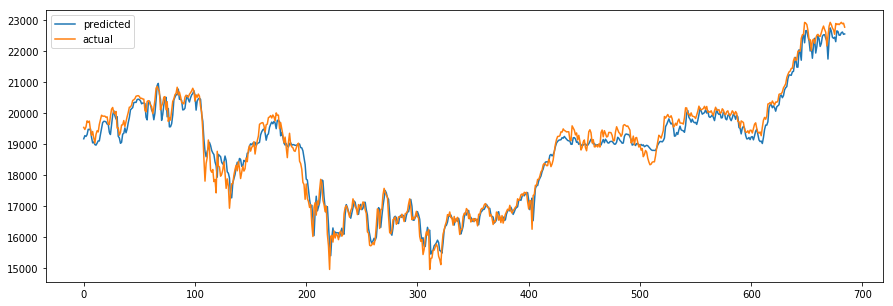

In [23]:
predicted_dash = scaler.inverse_transform(modeldash.predict(trainXdash[:1000]))
test_dash_df = pd.DataFrame(predicted_dash[:], columns=["predicted"])
test_dash_df["actual"] = trainY[:1000]
test_dash_df.plot(figsize=(15, 5))

"""
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['closing_price'], label="closing_price")
plt.fill_between(test_df.index, df['closing_price'].min(), df['closing_price'].max(), color='grey', alpha=0.3, 
                 label='Out-of-sample {}-{}'.format(test_df.first_valid_index().strftime('%Y/%m/%d'), test_df.last_valid_index().strftime('%m/%d')))
plt.title("NikkeiHeikin timeseries")
plt.legend()
plt.show()
"""

# 平均値から外れるほど精度が下がる, nが大きくなるほど一応精度は上がる

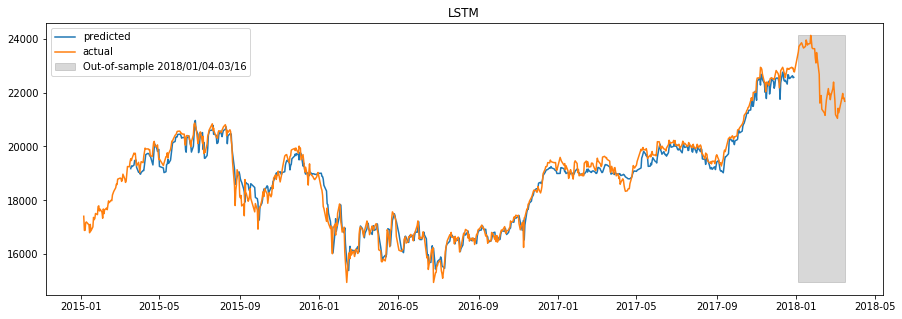

In [49]:
plt.figure(figsize=(15, 5))
plt.plot(trainIndex, predicted_dash, label="predicted")
plt.plot(df.index, df['closing_price'], label="actual")
plt.fill_between(test_df.index, df['closing_price'].min(), df['closing_price'].max(), color='grey', alpha=0.3, 
                 label='Out-of-sample {}-{}'.format(test_df.first_valid_index().strftime('%Y/%m/%d'), test_df.last_valid_index().strftime('%m/%d')))
plt.title("LSTM")
plt.legend()
plt.show()

Train on 698 samples, validate on 37 samples
Epoch 1/50
698/698 [==============================] - 3s 4ms/step - loss: 15.5953 - val_loss: 15.3348
Epoch 2/50
698/698 [==============================] - 0s 63us/step - loss: 8.3758 - val_loss: 9.7434
Epoch 3/50
698/698 [==============================] - 0s 64us/step - loss: 4.1983 - val_loss: 11.1977
Epoch 4/50
698/698 [==============================] - 0s 64us/step - loss: 3.9620 - val_loss: 5.9085
Epoch 5/50
698/698 [==============================] - 0s 66us/step - loss: 3.8266 - val_loss: 2.7597
Epoch 6/50
698/698 [==============================] - 0s 66us/step - loss: 4.1067 - val_loss: 7.1619
Epoch 7/50
698/698 [==============================] - 0s 56us/step - loss: 5.8166 - val_loss: 7.6857
Epoch 8/50
698/698 [==============================] - 0s 86us/step - loss: 4.5647 - val_loss: 2.7300
Epoch 9/50
698/698 [==============================] - ETA: 0s - loss: 2.707 - 0s 58us/step - loss: 4.0228 - val_loss: 9.6730
Epoch 10/50
698/698 

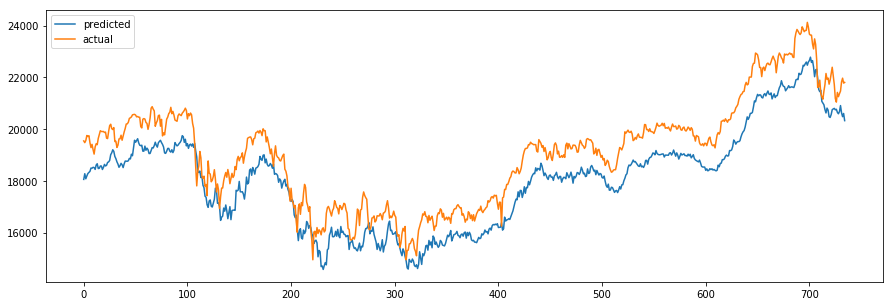

In [701]:
# create regression model
def reg_model(input_dim, hidden_dim):
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim))
    #model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
    #model.add(Dense(hidden_dim, activation='relu'))
    model.add(Dense(1))
    model.add(Activation("linear"))

    model.compile(loss="mape", optimizer="adam")
    return model

modelreg = reg_model(50, 200)
histreg = modelreg.fit(trainX_2d, trainY_1d, batch_size=32, epochs=50, validation_split=0.05)

predicted_reg = modelreg.predict(trainX_2d[:1000])
test_reg_df = pd.DataFrame(predicted_reg[:], columns=["predicted"])
test_reg_df["actual"] = trainY_1d[:1000]
test_reg_df.plot(figsize=(15, 5))

[ 0.00441237  0.0544054  -0.05277204  0.01096311 -0.08660996  0.15628161
 -0.04409252  0.03810759 -0.05200971 -0.05318356  0.06740317 -0.08818921
  0.02568197  0.06643372 -0.06502833  0.01714033  0.00505297  0.0088791
  0.01123788 -0.01125422 -0.04279283  0.06975433 -0.06235152 -0.01120696
  0.04833945  0.03728824 -0.12209871  0.01332634  0.08114914 -0.05792367
 -0.02153784  0.06316344 -0.04175047 -0.0049165   0.02918828 -0.041061
  0.08824291  0.01655792  0.01000159 -0.10242018 -0.00294929  0.05265159
 -0.0144717   0.0189624   0.01064044  0.00462257  0.01977667 -0.05091189
  0.04848497  0.94902066]


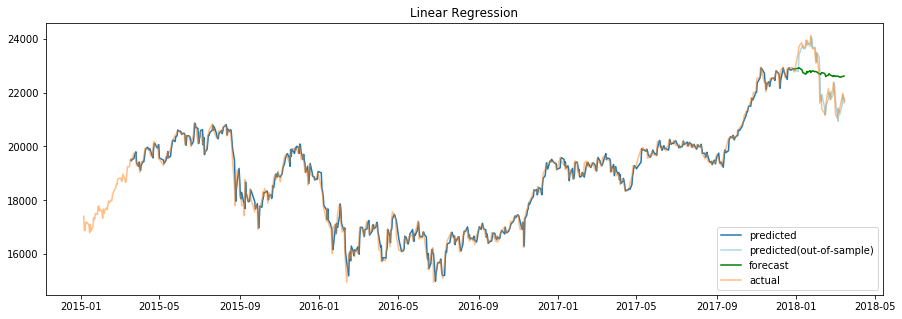

In [12]:
#重回帰分析

# ラッソ回帰 L1ノルム
# リッジ回帰 L2ノルム

from sklearn import linear_model
clf = linear_model.LinearRegression()

trainX_2d = trainX.reshape(-1, LENGTH_OF_SEQUENCE)
trainY_1d = trainY.reshape(-1)

clf.fit(trainX_2d, trainY_1d)

# 重要度分析
print(clf.coef_)

predicted_linear = clf.predict(trainX_2d)
test_linear = clf.predict(testX)

def forecast_clf(clf, x, periods):
    forecast_y = []
    for i in range(periods):
        y = clf.predict([x])
        forecast_y.append(y[0])
        x.pop(0)
        x.append(y)
        
    return forecast_y

forecast_linear = forecast_clf(clf, trainX_2d[-1].tolist(), len(test_df))

plt.figure(figsize=(15, 5))
plt.plot(df.index[LENGTH_OF_SEQUENCE:train_size-1], predicted_linear, label='predicted')
plt.plot(df.index[train_size-1:-1], test_linear, label='predicted(out-of-sample)', color='lightblue')
plt.plot(df.index[train_size-1:-1], forecast_linear, label='forecast', color='green')
plt.plot(df.index, df['closing_price'].values, label='actual', alpha=0.5)
plt.legend(loc='lower right')
plt.title("Linear Regression")
plt.show()

In [41]:
prstd_dash, iv_l_dash, iv_u_dash = wls_prediction_std(linear_clf, exog=np.insert(testX, 0, 1, axis=1), alpha=1-PREDICTION_INTERVAL)
pre_dash = linear_clf.predict(exog=np.insert(testX, 0, 1, axis=1))

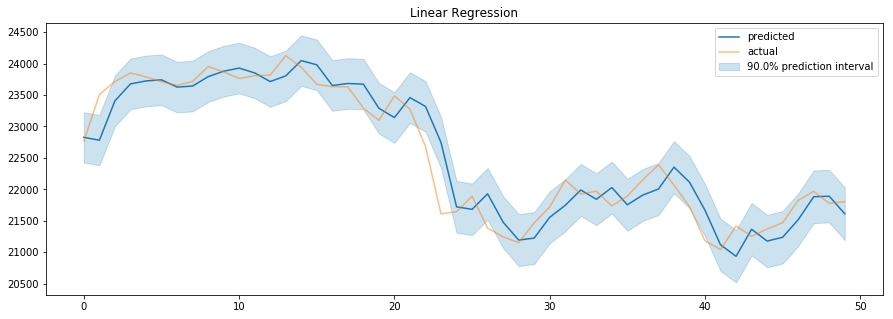

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(range(len(prstd_dash)), pre_dash, label="predicted")
plt.fill_between(range(len(prstd_dash)), iv_l_dash, iv_u_dash,
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(range(len(prstd_dash)), testY, label="actual", alpha=0.5)
plt.title("Linear Regression")
plt.legend()
plt.show()

In [369]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
# boosting interval


# https://github.com/statsmodels/statsmodels/blob/master/statsmodels/sandbox/regression/predstd.py
res = linear_clf
alpha = PREDICTION_INTERVAL
# conv : covariance matrix of parameter estimates
covb = res.cov_params()
# exogenous variables for points to predict
exog = res.model.exog
# res.fittedvalues : values used in estimation
predicted = res.fittedvalues
weights = res.model.weights
predvar = res.mse_resid/weights + (exog * np.dot(covb, exog.T).T).sum(1)
# predstd : standard error of prediction
predstd = np.sqrt(predvar)
tppf = stats.t.isf(alpha/2., res.df_resid)
interval_u = predicted + tppf * predstd
interval_l = predicted - tppf * predstd
print (interval_u, interval_l)

[19523.6358937  19494.09370287 19537.74833664 19589.02876884
 19715.89819513 19787.5522028  19831.66730196 19419.37576214
 19290.69448436 19452.72556041 19239.10379682 19137.51362077
 19324.79874965 19484.39137278 19460.03431367 19614.73987827
 19815.03362649 19937.22821206 20003.89481993 19934.38927509
 19895.19284411 19953.504713   19903.83466629 19662.6705282
 19606.5790614  19944.07125366 20129.37500766 20145.1091628
 19989.98630573 19974.24264611 20097.87317376 19604.72543147
 19524.51423731 19390.57940234 19513.39002264 19659.28572307
 19600.2845653  19837.30913809 19610.52281425 19665.07710552
 19896.47846115 20069.68279977 20224.36032016 20271.09934777
 20208.96344378 20396.73832745 20405.97300595 20427.4698531
 20640.27437188 20575.17154524 20600.88360401 20574.43472265
 20475.19265142 20513.01337341 20522.55654148 20467.4422267
 20141.86123889 20074.64537634 20432.39864116 20425.97120448
 20407.60239765 20356.81833951 20262.46776052 20080.20045509
 20209.98503097 20432.433642

In [ ]:
# https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
lm = LinearRegression()
lm.fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

# inv : inverse 逆行列
# diagonal : 対角行列の成分を抜き取る
var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
print(myDF3)

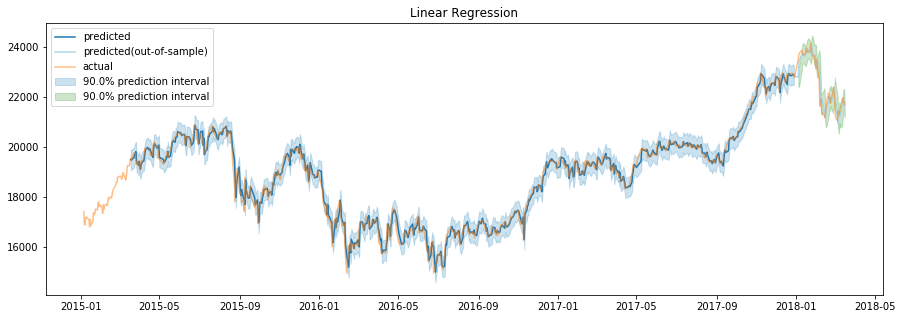

In [51]:
# 重回帰
# 誤差分布には正規分布を仮定していることに注意してください。正規分布以外の確率分布が相手だった場合は、状態空間モデル等で対応することになります。
# 時系列データにOLSを適用すると見せかけの回帰になる。普通はGLSで回帰する(嘘、GLSでなく差分系列で回帰した方が良い？)
# https://logics-of-blue.com/time-series-regression/

# http://tarohmaru.web.fc2.com/R/Diagnostics.html
# 残差分散が不均一になる場合、重み付き最小二乗法 (Weighted Least Square: WLS) で推定する
# 残差の分散について事前の知識などない場合が多いだろう。そのような場合は、データから残差の分散を推定する。推定には、nlmeパッケージの gls() 関数を使う。

# 誤差項の共分散行列 Ω は既知であるか、あるいは、漸近的に真の値に近づくことを仮定してきた。

# 株価はランダムウォークで分析しても大差がないとも。回帰を取るにも階差を取るのが一般的
# http://hosho.ees.hokudai.ac.jp/~kubo/stat/2015/hro/hro10/kubo2015hro10.pdf

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt

linear_clf = sm.OLS(trainY_1d, sm.add_constant(trainX_2d)).fit()

prstd, iv_l, iv_u = wls_prediction_std(linear_clf, alpha=1-PREDICTION_INTERVAL)

# 切片1を追加
prstd_test, iv_l_test, iv_u_test = wls_prediction_std(linear_clf, exog=np.insert(testX, 0, 1, axis=1), alpha=1-PREDICTION_INTERVAL)
fittedvalues_test = linear_clf.predict(exog=np.insert(testX, 0, 1, axis=1))

plt.figure(figsize=(15, 5))

#plt.plot(df.index[LENGTH_OF_SEQUENCE:train_size-1], predicted_linear, label='predicted')
#plt.plot(df.index[train_size-1:-1], test_linear, label='predicted(out-of-sample)', color='lightblue')
#plt.plot(df.index[train_size-1:-1], forecast_linear, label='forecast', color='green')
#plt.plot(df.index, df['closing_price'].values, label='actual', alpha=0.5)

plt.plot(trainIndex, linear_clf.fittedvalues, label="predicted")
plt.plot(df.index[train_size-1:-1], fittedvalues_test, label='predicted(out-of-sample)', color='lightblue')
plt.fill_between(trainIndex.reshape(-1), iv_l, iv_u,
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.fill_between(df.index[train_size:], iv_l_test, iv_u_test,
                 color='green', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(df.index, df['closing_price'].values, label="actual", alpha=0.5)
plt.title("Linear Regression")
plt.legend()
plt.show()

# Out of sample Bug
# https://stackoverflow.com/questions/32593522/return-std-and-confidence-intervals-for-out-of-sample-prediction-in-statsmodels/32594835#32594835

# http://www.statsmodels.org/0.6.1/examples/notebooks/generated/predict.html

In [473]:
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     980.0
Date:                Sun, 25 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:48:24   Log-Likelihood:                -5049.9
No. Observations:                 735   AIC:                         1.020e+04
Df Residuals:                     684   BIC:                         1.044e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.9817    100.148      0.779      0.436    -118.652     274.616
x1             0.0047      0.040      0.118      0.906      -0.073       0.083
x2             0.0567      0.055      1.041      0.298      -0.050       0.164
x3            -0.0573      0.054     -1.052      0.293      -0.164       0.050
x4             0.0048      0.055      0.089      0.929      -0.102       0.112
x5            -0.0920      0.054     -1.689      0.092      -0.199       0.015
x6             0.1584      0.054      2.927      0.004       0.052       0.265
x7            -0.0415      0.054     -0.767      0.443      -0.148       0.065
x8             0.0442      0.054      0.815      0.415      -0.062       0.151
x9            -0.0716      0.054     -1.322      0.187      -0.178       0.035
x10           -0.0542      0.054     -1.001      0.317      -0.161       0.052
x11            0.0985      0.054      1.823      0.069      -0.008       0.205
x12           -0.0852      0.054     -1.573      0.116      -0.192       0.021
x13            0.0328      0.054      0.606      0.544      -0.073       0.139
x14            0.0425      0.054      0.784      0.433      -0.064       0.149
x15           -0.0624      0.054     -1.153      0.249      -0.169       0.044
x16            0.0153      0.054      0.282      0.778      -0.091       0.122
x17            0.0092      0.054      0.170      0.865      -0.097       0.116
x18            0.0236      0.054      0.435      0.664      -0.083       0.130
x19            0.0089      0.054      0.164      0.870      -0.098       0.115
x20           -0.0200      0.054     -0.368      0.713      -0.127       0.087
x21           -0.0738      0.054     -1.363      0.173      -0.180       0.032
x22            0.0844      0.054      1.560      0.119      -0.022       0.191
x23           -0.0338      0.054     -0.624      0.533      -0.140       0.073
x24           -0.0093      0.054     -0.172      0.864      -0.116       0.097
x25            0.0389      0.054      0.721      0.471      -0.067       0.145
x26            0.0329      0.054      0.611      0.542      -0.073       0.139
x27           -0.1138      0.054     -2.124      0.034      -0.219      -0.009
x28            0.0135      0.054      0.252      0.801      -0.092       0.119
x29            0.0966      0.053      1.806      0.071      -0.008       0.202
x30           -0.0628      0.053     -1.175      0.241      -0.168       0.042
x31           -0.0253      0.054     -0.473      0.637      -0.130       0.080
x32            0.0476      0.053      0.889      0.374      -0.057       0.153
x33           -0.0771      0.053     -1.447      0.148      -0.182       0.028
x34            0.0074      0.053      0.140      0.889      -0.097       0.112
x35            0.0568      0.053      1.069      0.286      -0.048       0.161
x3

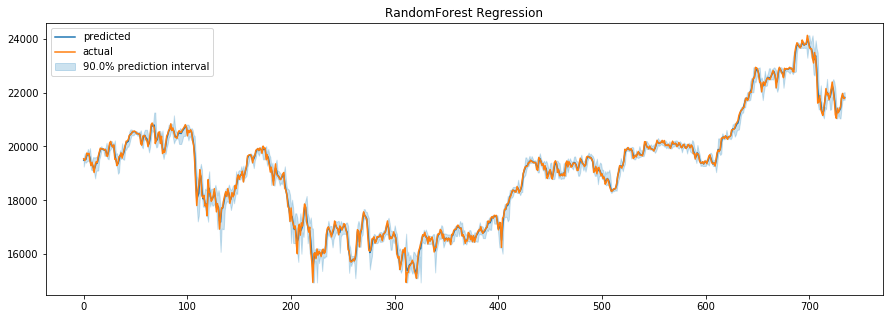

In [481]:
# RandomForest Regression
from sklearn.ensemble import RandomForestRegressor
r_forest = RandomForestRegressor(
            n_estimators=100,
            criterion='mse',
            random_state=1,
            n_jobs=-1
)

r_forest.fit(trainX_2d, trainY_1d)

predicted_rf = r_forest.predict(trainX_2d[:1000])

# http://blog.datadive.net/prediction-intervals-for-random-forests/
def pred_ints(model, X, prediction_interval):
    alpha = 100 - prediction_interval * 100
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict([X[x]])[0])
        err_down.append(np.percentile(preds, alpha / 2. ))
        err_up.append(np.percentile(preds, 100 - alpha / 2.))
    return err_down, err_up

iv_l, iv_u = pred_ints(r_forest, trainX_2d, prediction_interval=PREDICTION_INTERVAL)

plt.figure(figsize=(15, 5))
plt.plot(range(len(trainY_1d)), predicted_rf, label="predicted")
plt.fill_between(range(len(trainY_1d)), iv_l, iv_u,
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(range(len(trainY_1d)), trainY_1d, label="actual")
plt.legend()
plt.title("RandomForest Regression")
plt.show()

/home/ksgwr/venv/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ksgwr/venv/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/ksgwr/venv/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/ksgwr/venv/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available

(1, 0)
(1, 0)


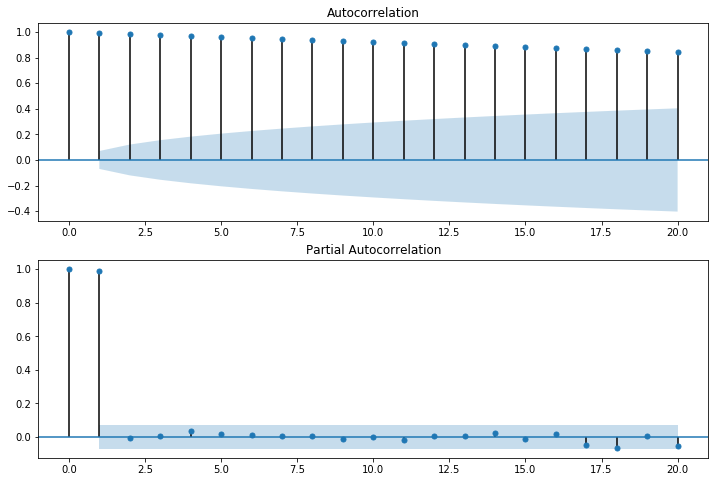

In [345]:
# ARMAのパラメータ分析
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['closing_price'].values, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['closing_price'].values, lags=20, ax=ax2)
fig.show()

info_criteria = sm.tsa.stattools.arma_order_select_ic(
                    df['closing_price'].values, ic=['aic', 'bic']
                )
print(info_criteria.aic_min_order)
print(info_criteria.bic_min_order)

arma aic: 10124.92881768999
arma mse: 58540.28600915017


/home/ksgwr/venv/lib/python3.5/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1470: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


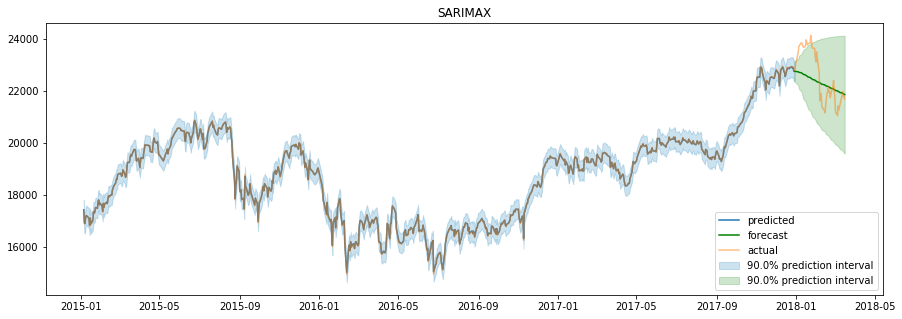

In [185]:
# SARIMAX
import matplotlib.pyplot as plt
from pandas.core import datetools
import statsmodels.api as sm

# 自己回帰パラメータ(AR)
p = 1
# 差分の階数(I)
d = 0
# 移動平均パラメータ(MA)
q = 1
# c’ indicates a constant (i.e. a degree zero component of the trend polynomial)
sarimax=sm.tsa.SARIMAX(train_df[['closing_price']], trend='c', order = [p,d,q]).fit()
print("arma aic:", sarimax.aic)
print("arma mse: {}".format(np.array([r ** 2 for r in sarimax.resid]).mean()))

train_size = len(train_df)

predicted_sarimax = sarimax.get_prediction(start=1, end=train_size+len(test_df), dynamic=train_size)
conf_sarimax = predicted_sarimax.conf_int(alpha=1-PREDICTION_INTERVAL)

plt.figure(figsize=(15, 5))
plt.plot(df.index[:train_size], predicted_sarimax.predicted_mean[:train_size], label='predicted')
plt.plot(df.index[train_size-1:], predicted_sarimax.predicted_mean[train_size-1:], label='forecast', color='green')
plt.fill_between(df.index[:train_size], conf_sarimax['lower closing_price'][:train_size], conf_sarimax['upper closing_price'][:train_size],
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.fill_between(df.index[train_size-1:], conf_sarimax['lower closing_price'][train_size-1:], conf_sarimax['upper closing_price'][len(train_df)-1:],
                 color='green', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(df.index, df['closing_price'].values, label='actual', alpha=0.5)
plt.legend(loc='lower right')
plt.title("SARIMAX")
plt.show()

p = 1 ~ 20
q = 0 or 1

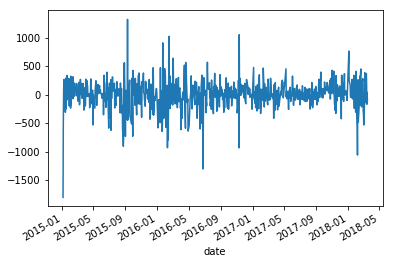

In [348]:
arma.resid.plot()

In [439]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          closing_price   No. Observations:                  786
Model:                     ARMA(1, 1)   Log Likelihood               -5419.517
Method:                       css-mle   S.D. of innovations            238.273
Date:                Sat, 24 Mar 2018   AIC                          10847.033
Time:                        21:19:51   BIC                          10865.701
Sample:                    01-05-2015   HQIC                         10854.211
                         - 03-16-2018                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.921e+04   1040.199     18.470      0.000    1.72e+04    2.13e+04
ar.L1.closing_price     0.9931      0.004    251.080      0.000       0.985       1.001
ma.L1.closing_price    -0.0208      0.037     -0.569      0.569      -0.092       0.051
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0069           +0.0000j            1.0069            0.0000
MA.1           48.1150           +0.0000j           48.1150            0.0000
-----------------------------------------------------------------------------
"""

In [159]:
from fbprophet import Prophet

# prophetのMAP推定を行う際にデフォルトでstanに搭載されているL-BFGSという最適化手法を実行する

train_df['y'] = train_df['closing_price']
train_df['ds'] = train_df.index
prophet = Prophet(interval_width=PREDICTION_INTERVAL)
prophet.fit(train_df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ksgwr/venv/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


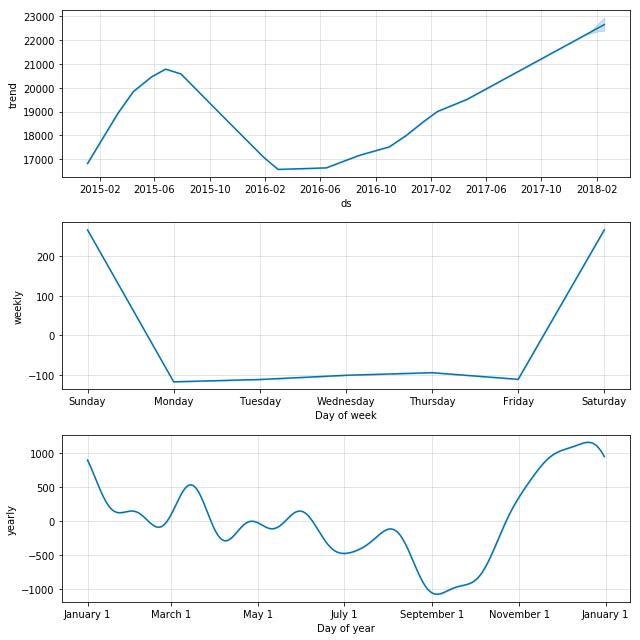

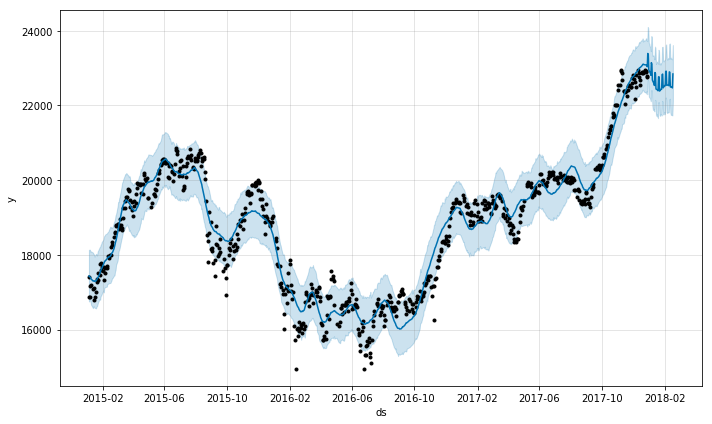

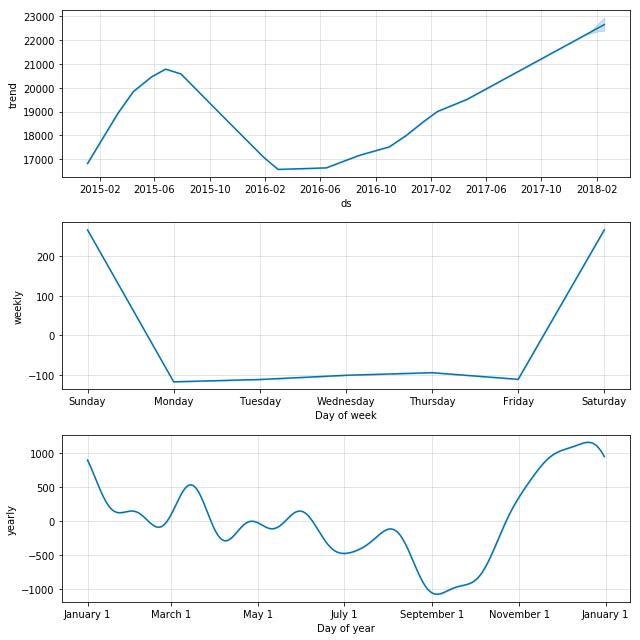

In [187]:
future_prophet = prophet.make_future_dataframe(periods=len(test_df))
predicted_prophet = prophet.predict(future_prophet)
prophet.plot(predicted_prophet)
prophet.plot_components(predicted_prophet)

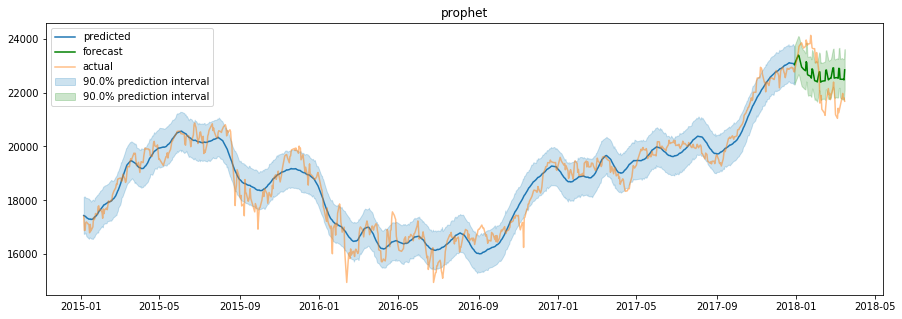

In [336]:
train_size = len(train_df)

plt.figure(figsize=(15, 5))
plt.plot(df[:train_size].index, predicted_prophet[:train_size]['yhat'].values, label='predicted')
plt.fill_between(df[:train_size].index, predicted_prophet[:train_size]['yhat_lower'], predicted_prophet[:train_size]['yhat_upper'],
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(df.index[train_size-1:], predicted_prophet[train_size-1:]['yhat'].values, label='forecast', color='green')
plt.fill_between(df.index[train_size-1:], predicted_prophet[train_size-1:]['yhat_lower'], predicted_prophet[train_size-1:]['yhat_upper'],
                 color='green', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(df.index, df['closing_price'].values, label='actual', alpha=0.5)
plt.legend()
plt.title('prophet')
plt.show()

In [254]:
# sklearn 線形回帰
# https://pythondatascience.plavox.info/scikit-learn/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0
# ARMA, RandomForest
# https://qiita.com/TomokIshii/items/b3ebe2b60c5d3d5a0d5a
# sklearn 重回帰
# https://qiita.com/yossyyossy/items/ac6961ca5a0e765f56be
# https://github.com/facebook/prophet

# 株価予測
# https://ci.nii.ac.jp/els/contentscinii_20170914111846.pdf?id=ART0008908455

# 時系列解析の欠損値
# https://qiita.com/kilometer/items/68b5a0e9ebff45f0ebc6

# 単回帰の導出が丁寧
# http://racco.mikeneko.jp/Kougi/10s/AS/AS02pr.pdf

TODO: prophetとARMAで予測
    未来予測の評価まで行う
    信頼区間もプロットする
 
時系列モデルで出したいのは未来予測でなくトレンド！
    
株価予測のアプローチ  
* 時系列モデルでトレンドを加味した常識的な範囲（人間が手で書けるレベル)を予測、イベント的な素性の強弱を学習  
     時系列モデルができれば、外れ値がわかる、そこから重要な影響を与える因子を人間が推測して素性として選別する、もしくは直感で素性作成  
     素性毎の影響度は人間が採点するのは難しいのでそこを機械学習、また時間経過の減衰などもモデルとして組み込める  
     直感的に理解できる素性を組み込んでいきたい方向性
     
* 近傍探索を利用して過去の類似事例から人間が予測  
     固定長の系列を例えば値を直接であったり、各サンプル毎の平均値からの残差（波形の形）を事前にインデックス  
     バリューに未来の系列値やイベントを格納しておく  
     未来予測は過去の事例をそのまま重ねることができる。その時の状況を人間が加味してそれらしい予測を選択する